<h1> sourdough microbiome and flavor </h1>


In the original study, 40 starters were picked for functional analysis and 17 were associated with green apple or fruity aromas. These "fruity starters" sound very intriguing to me and I want to try to culture one for myself and see if they impart the fruity notes to my bread. To do that I'll have to mimic the conditions that these starters were cultured in and I'll start with visualising the metadata of these 17 starters.

In [1]:
%matplotlib inline 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

<h3> Initial analysis of sourdough starters with fruity/apple notes </h3>

In [394]:
# read metadata for starters
metadata = pd.read_csv('data\metadata500_starters.csv')
metadata.rename(columns={'Unnamed: 0': 'sample'}, inplace=True)

print(metadata.columns)

Index(['sample', 'sample_type', 'Type', 'Flag', 'Entry.Id', 'CurrentLat',
       'CurrentLong', 'grain.base.rye', 'grain.base.bleached.wheat',
       'grain.base.whole.wheat', 'grain.base.unbleached', 'City',
       'State.Province.Region', 'Country', 'Starter.age.years', 'WhoMadeBin',
       'StorageLocBin', 'FeedPerMo', 'Fruity', 'Sour', 'musty', 'medicinal',
       'biscuity', 'floral', 'NoSmell', 'FreqOpenedPerWeek', 'tap', 'filtered',
       'bottled', 'rainwater', 'snow', 'well', 'otherWater', 'Cat', 'Dog',
       'ContainerMaterial', 'ContainerLid', 'Temp', 'Seasnlty', 'MaxTemp',
       'MinTemp', 'Prec', 'npp'],
      dtype='object')


In [401]:
# combine flours used into 1 column and clean up the names

rep = {k:v for k,v in zip(metadata.columns[7:11], metadata.columns[7:11].str.replace(r'grain.base.|.wheat', '', regex=True))}

for col in metadata.columns[7:11]:
    metadata[col] = metadata[col].replace(1.0, rep[col])

metadata['flour'] = metadata[metadata.columns[7:11]].apply(lambda x: '\n+ '.join(x.replace(0.0, np.nan).dropna().astype(str)), axis=1)

In [396]:
# read sensory note file and filter for samples with apple/fruit aromas
sensory = pd.read_excel('data\Figure_4_-_Source_Data_2.xlsx')
mask = sensory['Note 1 (Dominant)'].str.contains(r'fruit|apple') | sensory['Note 2 (Secondary)'].str.contains(r'fruit|apple')

# get metadata for desired samples
desired_samples = metadata[metadata['sample'].isin(sensory['Sample'][mask])]

print(f'{desired_samples["Country"].value_counts()}')

Country
United States    14
Canada            3
Name: count, dtype: int64


Note that the metadata also includes aroma descriptors that are self-reported and since every individual preceives smells differently, I won't be using them. I will also be ignoring any factors that I cannot control, such as country, presence of pets etc.

In [462]:
def visualise_metadata(df):
    ''' function to visualise metadata that I can copy in my kitchen'''
    from matplotlib.gridspec import GridSpec


    fig = plt.figure(figsize=(18, 10))
    gs = GridSpec(2,3)

    ax1 = fig.add_subplot(gs[0,:2])
    sns.countplot(x=df['flour'], ax=ax1)
    ax1.tick_params(axis='x', labelsize='small')
    ax1.set_title('Flour')


    ax2 = fig.add_subplot(gs[0,2])
    sns.barplot(df.iloc[:, 26:33].sum(axis=0), ax=ax2)
    ax2.tick_params(axis='x', labelsize='x-small')
    ax2.set_title('Water')


    ax3 = fig.add_subplot(gs[1,0])
    sns.countplot(df, x='ContainerMaterial', ax=ax3)
    ax3.tick_params(axis='x', labelsize='x-small')
    ax3.set_title('Container')


    ax4 = fig.add_subplot(gs[1,1])
    sns.countplot(x = df.iloc[:, 16], ax=ax4)
    ax4.tick_params(axis='x', labelsize='x-small')
    ax4.set_title('storage')


    ax5 = fig.add_subplot(gs[1,2])
    sns.stripplot(df.iloc[:, [14,17,25]], ax=ax5)
    n = 0
    
    for i in df.iloc[:, [14,17,25]]:
        avg = df[i].median()
        ax5.annotate(np.round(avg,2),
            xy=(n+0.2, ax5.get_ylim()[1]/2), xycoords='data',
            # xytext=(.3, 0.5), textcoords='axes fraction',
            horizontalalignment="center")
        n+=1

    plt.tight_layout()

    print(f'{df["Country"].value_counts()}')


Country
United States    14
Canada            3
Name: count, dtype: int64


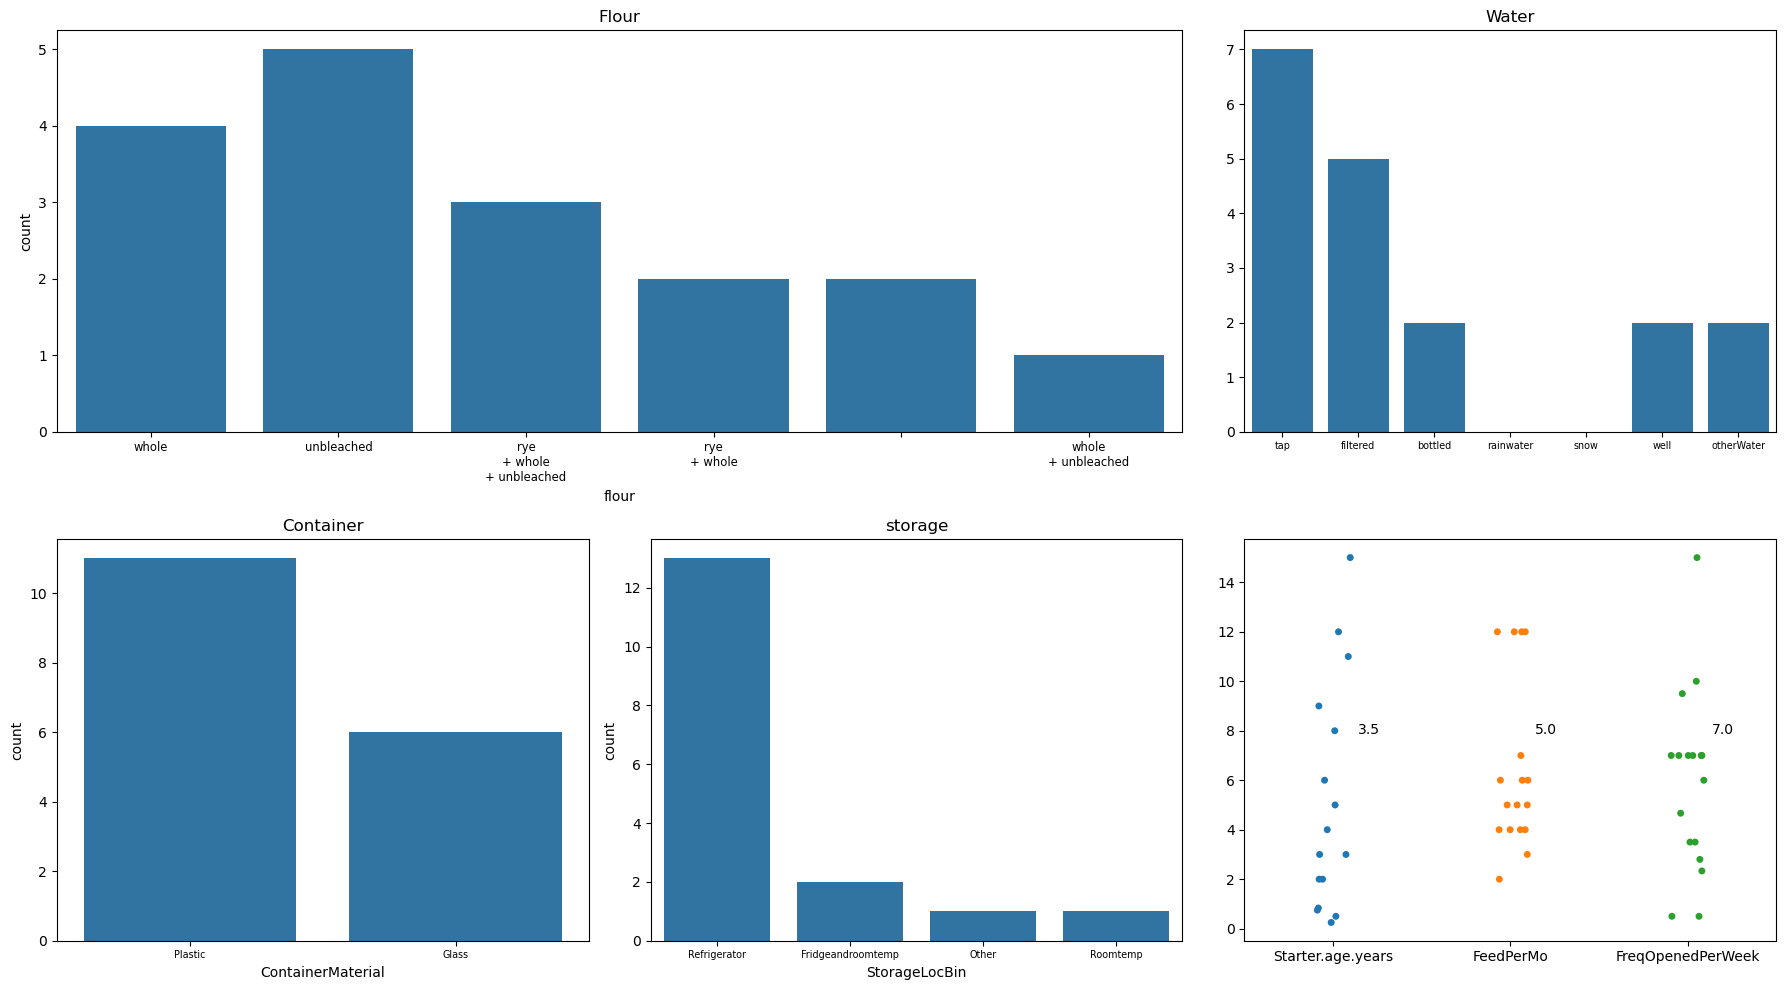

In [463]:
visualise_metadata(desired_samples)

From the plots, it is pretty clear the 17 starters are cultured in quite different conditions and there is a wide range of ages and feeding frequency as well. Some participants also used a mixture of flours and waters in the starters so the total for these categories is larger than 17. The conclusion after this initial exploration is that 17 samples apparently isn't enough to find any pattern in the culture condition. Since the microbes are responsible for the flavors of the starters, I can "increase" my sample size by looking for starters with similar microbial population in the dataset by clustering the sequencing data.

In [7]:
# read and transpose data since the variables (ASVs) are rows in the raw data
bact = pd.read_csv("data\sourdough_tab_16S.csv").set_index('Unnamed: 0').T.reset_index()
fung = pd.read_csv("data\sourdough_tab_ITS.csv").set_index('Unnamed: 0').T.reset_index()

# rename column and index for clarity
bact = bact.rename(columns={'index':'samples'}).rename_axis(None, axis=1)
fung = fung.rename(columns={'index':'samples'}).rename_axis(None, axis=1)

print(f'bacteria data size: {bact.shape}\nsparsity: {1 - (np.count_nonzero(bact)/(bact.shape[0]*bact.shape[1])):.3f}')
print()     
print(f'fungi data size: {fung.shape}\nsparsity: {1 - (np.count_nonzero(fung)/(fung.shape[0]*fung.shape[1])):.3f}')

bacteria data size: (500, 439)
sparsity: 0.982

fungi data size: (500, 1520)
sparsity: 0.976


The sequencing data is high dimensional and very sparse, so I'll start with reducing the dimensions of the dataset. The simplest way would be to only analyse sourdough fermentation-relevant microbes and drop all other microbial species. But I'm thinking that even though some bacteria are not relevant to sourdough, they might still be *associated* to the culture conditions. For example, non-relevant bacteria B may not ferment flour but if it prefers similar conditions as relevant bacteria A that produces a desirable flavor, then its abundance data is still useful information. So I'll try to keep all the microbe data if I can. 

I noticed that in the taxonomy data, there are actually a number of ASVs identified as the same species. To reduce the data size, I'll assume that these are sub-strains or at least closely related species and aggregate these ASVs by summing their relative abundance for every sample

In [3]:
bact_tax = pd.read_csv("data\sourdough_tax_16S.csv")
fung_tax = pd.read_csv("data\sourdough_tax_ITS.csv")

In [4]:
# combine tax 6 and 7 to make a genus-species identifier for all ASVs
bact_tax['species'] = bact_tax['taxonomy6'] +"_"+ bact_tax['taxonomy7']
fung_tax['species'] = fung_tax['taxonomy6'].str.replace('g__', "") +"_"+ fung_tax['taxonomy7'].str.replace('s__', "")

# some ASVs are not identified at the genus/species level, use the ASV as an identifier instead
bact_tax['species'].fillna(bact_tax['taxonomy8'], inplace=True)
fung_tax['species'].fillna(fung_tax['taxonomy8'], inplace=True)

In [5]:
def aggregate_same_species(abund_df, tax_df):
    '''aggregate ASVs identified as the same species by summing their abundance, species of ASVs are referred from tax_df.
    '''
    
    # ensure ASVs is in the same order in both dfs
    assert sum(bact_tax['taxonomy8'] == bact.columns[1:]), "ASVs not in same order!"

    # collect ASVs with the same species
    from collections import defaultdict
    dict = defaultdict(list)
    for i in range(len(tax_df)):
        dict[tax_df['species'][i]].append(tax_df['taxonomy8'][i])

    # new df for aggregated abundance data 
    new_df = abund_df.iloc[:, :1].copy()
    
    # sanity check for total ASVs
    n = 0

    for species in list(dict.keys()):
        col_names = list(new_df.columns) + [species]
        new_df = pd.concat([new_df, abund_df.loc[:, dict[species]].sum(axis=1)], axis=1)
        n += len(dict[species])
        new_df.columns = col_names

    # sanity check
    assert n == abund_df.shape[1]-1, 'not all ASVs collected, check outputs'

    return new_df

Text(0.5, 1.0, 'fungi data: (500, 741)')

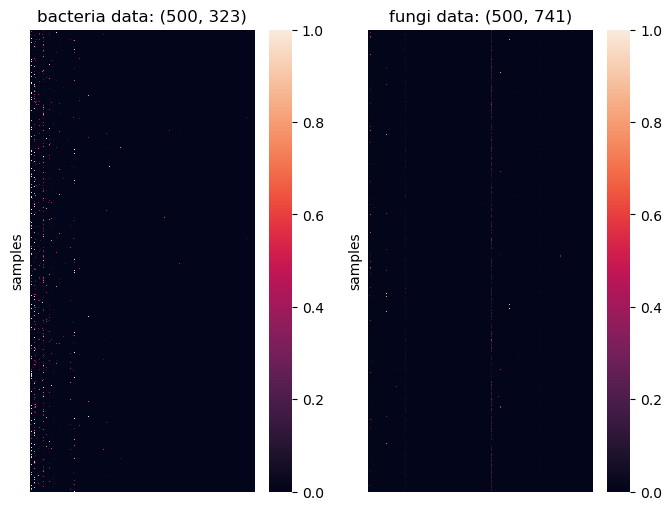

In [8]:
# aggregate similar species and visualise the data this time
bact_agg = aggregate_same_species(bact, bact_tax)
fung_agg = aggregate_same_species(fung, fung_tax)

fig = plt.figure(figsize = (8, 6))

ax1 = fig.add_subplot(1, 2, 1)
sns.heatmap(data = bact_agg.set_index('samples'), ax=ax1, yticklabels=False, xticklabels=False)
ax1.set_title(f'bacteria data: {bact_agg.shape}')

ax2 = fig.add_subplot(1, 2, 2)
sns.heatmap(data = fung_agg.set_index('samples'), ax=ax2, yticklabels=False, xticklabels=False)
ax2.set_title(f'fungi data: {fung_agg.shape}')

I only managed to half the dimensions of the fungi data but it's still too big and both sets of data are still too sparse. Next is to try more dimensionality reduction techniques. PCA is first to come to mind, but it needs the data to be centered and given how sparse the data is, it might not work well. First, let's visualise the data in a lower dimensional space before deciding.

Interesting, it seems like there is a group of starters separate from the rest and there is another *3-4?* clusters. After consulting stack overflow and google, I've decided to use truncated SVD to reduce dimensions and followed by hierarchical clustering since it is one of the preferred methods when clustering microbiome data.

In [10]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import TruncatedSVD

# merge and save dataframes
# combined = bact_agg.merge(fung_agg, left_on='samples', right_on='samples')
# combined.to_csv('data/combined.csv')

# after some tuning, I decided on 30 components 
tsvd = TruncatedSVD(n_components=30, n_iter=8).fit(combined.iloc[:, 1:])

x_svd = tsvd.transform(combined.iloc[:, 1:])

print(f'total explained variance: {tsvd.explained_variance_ratio_.sum():.3f}')

total explained variance: 0.954


In [11]:
# find best number of clusters based on silhouette score up to 8 clusters

from sklearn import metrics
from sklearn.model_selection import GridSearchCV

agg = AgglomerativeClustering(linkage='ward')

def silhouette_score(estimator, X):
    estimator.fit(X)
    labels = estimator.labels_

    return metrics.silhouette_score(X, labels)

params = [{'n_clusters':range(8)[3:]}]

agg_gs = GridSearchCV(estimator=agg, param_grid=params, scoring=silhouette_score, n_jobs=4).fit(x_svd)

print(f'best parameters: {agg_gs.best_params_}')

best parameters: {'n_clusters': 7}


In [57]:
svd_agg = AgglomerativeClustering(n_clusters=7).fit(x_svd)

# create new df with cluster labels
groups = combined.assign(clusters=svd_agg.labels_)

Next let's visualise the results with t-SNE.

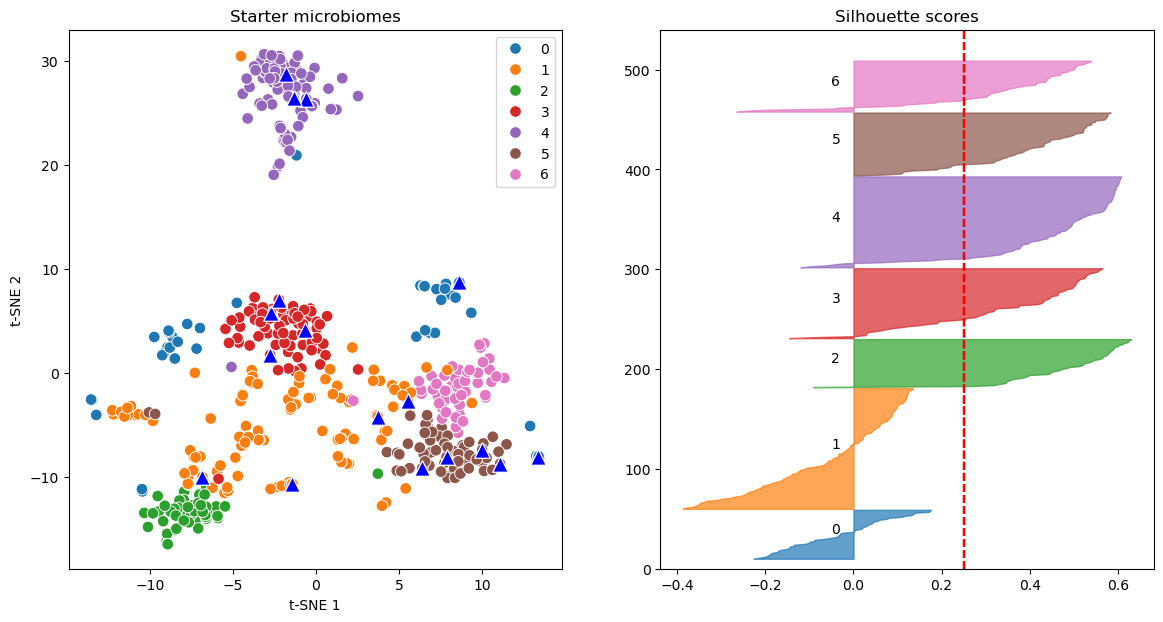

In [58]:
from sklearn.manifold import TSNE
import matplotlib.lines as mlines
# get TSNE embeddings and convert to dataframe for ease of seaborn plots
microbe_embed = TSNE(n_components=2, perplexity=50, learning_rate='auto', init='random').fit_transform(combined.iloc[:, 1:])
microbe_embed = pd.DataFrame(microbe_embed, columns = ['t-SNE 1', 't-SNE 2'])

# create mask for desired samples in all samples
new_mask = combined['samples'].isin(sensory['Sample'][mask])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,7))

sns.scatterplot(microbe_embed, x='t-SNE 1', y='t-SNE 2', ax=ax1, hue= groups['clusters'], palette=sns.color_palette(n_colors=7), s=70)
sns.scatterplot(microbe_embed[new_mask], x='t-SNE 1', y='t-SNE 2', ax=ax1, c='b', marker='^', s=125)
triangle = mlines.Line2D([], [], color='b', marker='^', linestyle='None',
                        markersize=10, label='triangles')

ax1.set_title('Starter microbiomes')

silhou_scores = metrics.silhouette_samples(x_svd, svd_agg.labels_)
silhou_average = metrics.silhouette_score(x_svd, svd_agg.labels_)

ax2.set_ylim([0, len(x_svd) + 40])
y_lower = 10
for i in range(7):
    # Aggregate the silhouette scores for each cluster i and sort them
    i_cluster_silhouette_values = silhou_scores[svd_agg.labels_ == i]

    i_cluster_silhouette_values.sort()

    size_cluster_i = i_cluster_silhouette_values.shape[0]

    y_upper = y_lower + size_cluster_i

    color = sns.color_palette()[i]
    ax2.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        i_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    ax2.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    ax2.axvline(x=silhou_average, color="red", linestyle="--")
    y_lower = y_upper

    ax2.set_title('Silhouette scores')

The desired starters are represented as blue triangles in the left plot and the red broken line indicates the average silhouette score. Overall, the average silhouette score isn't very high but there's still good insights to move forward on for my analysis:

1. Samples in clusters 2-6 are clustered well enough to work on.
2. Clusters 3, 4 and 5 contains about 3-4 desired starters each, this is not unexpected, since different microbiomes can definitely produce similar sensory notes. It would be nice if I can find some similar culture conditions between them and use that for my starters to maximise my chances of getting a fruity starter.

Next I'll update the metadata and desired samples df with cluster information then filter for clusters 3-5.

In [408]:
metadata = metadata.merge(groups.loc[:, ['samples','clusters']], left_on='sample', right_on='samples')
desired_samples = metadata[metadata['sample'].isin(sensory['Sample'][mask])]

for i in [3,4,5]:
    print(f'cluster {i} has {sum(metadata["clusters"] == i)} samples')

print()
print(desired_samples['clusters'].value_counts())

cluster 3 has 71 samples
cluster 4 has 92 samples
cluster 5 has 64 samples

clusters
3    4
5    4
1    4
4    3
0    2
Name: count, dtype: int64


Looks like the clusters 3-5 have similar number of desired starters. Next I'll visualise the known dominant sensory notes of starters in these three clusters.

<Axes: xlabel='clusters'>

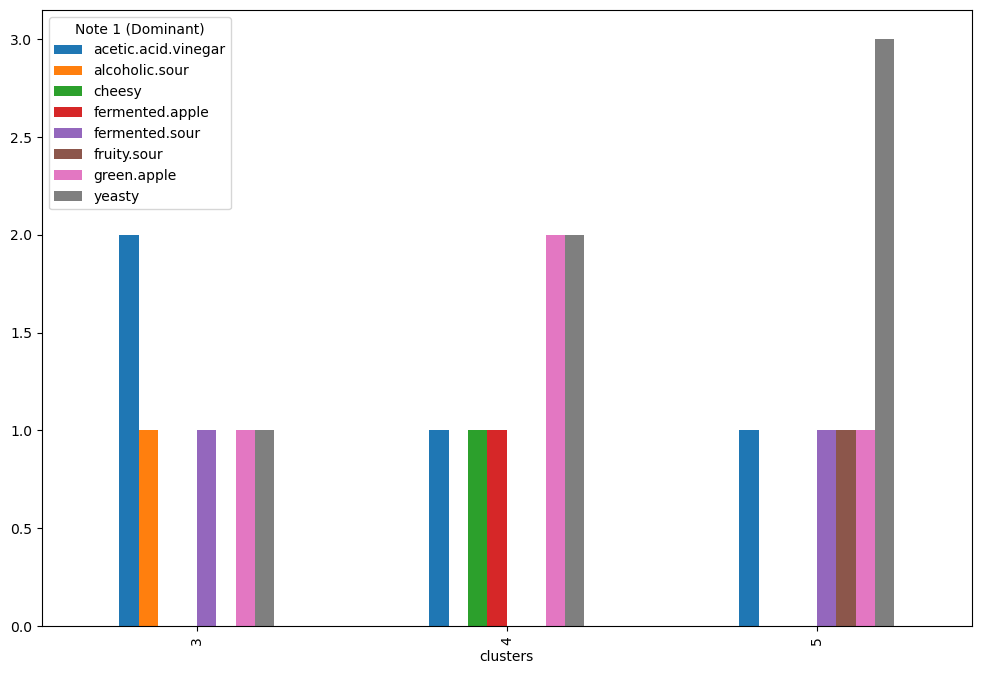

In [410]:
sensory = sensory.merge(groups.loc[:, ['samples','clusters']], left_on='Sample', right_on='samples')

clusts = sensory[sensory['clusters'].isin([3,4,5])][['clusters','Note 1 (Dominant)','samples']]

clusts_grp = clusts.groupby(['clusters','Note 1 (Dominant)'], as_index=False).count()

clusts_grp.pivot(index='clusters', columns='Note 1 (Dominant)', values='samples').plot(kind='bar', figsize=(12,8))

Since I'm looking for fruity flavors, cluster 4 looks to be the most promising. I'll finish up this analysis with a plot of its culture conditions.

Country
United States     75
Canada             8
Australia          3
France             2
United Kingdom     2
Finland            1
Netherlands        1
Name: count, dtype: int64


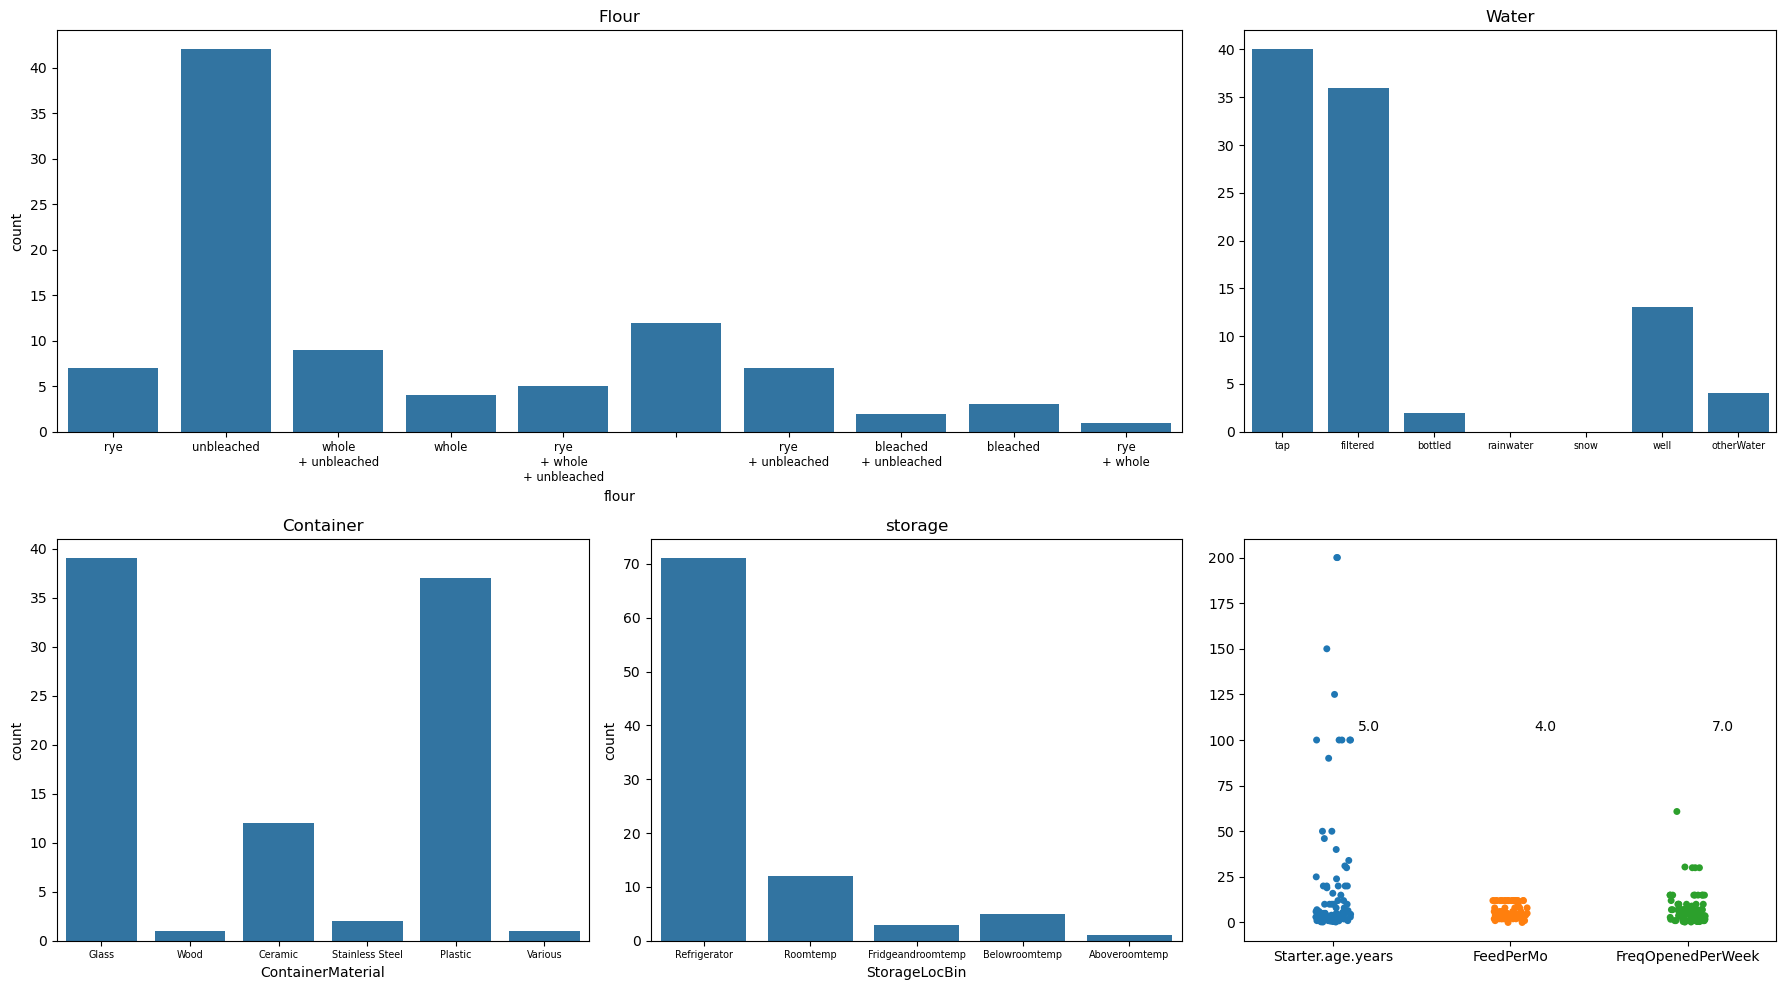

In [464]:
visualise_metadata(metadata[metadata['clusters'] == 4])

I am not seeing a clear pattern here unfortunately, but it seems like the most common conditions are:

1. Unbleached flour
2. Tap or filtered water
3. Glass or plastic container
4. Weekly feeds and opened daily

However, median starter age is 5 does that mean I'll need 5 years before finding out the results of this experiment?

Only one way to find out...